## Reddit Comments: Masked Language Modeling

Dataset Source: https://www.kaggle.com/datasets/toygarr/datasets-for-natural-language-processing

#### Install Missing Libraries

In [1]:
%pip install datasets transformers torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

#### Import Necessary Libraries

In [2]:
import os, sys, random, math

import pandas as pd

import matplotlib.pyplot as plt

import torch

import datasets
from datasets import ClassLabel, Dataset, DatasetDict

import transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer, set_seed

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### HuggingFace Access

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Mount Google Drive

In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


#### Display Library Versions

In [5]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.16
        Pandas: 1.4.4
      Datasets: 2.10.1
  Transformers: 4.27.0


#### Load Training Dataset

In [7]:
parent_dir = "/content/drive/MyDrive"

train_data_file = os.path.join(parent_dir, "train.csv")

train_data = pd.read_csv(train_data_file, usecols=["text"])

train_data = train_data.drop_duplicates()
train_data = train_data.dropna()

train_data

,text
0,"I don't know man, that Jeep looks really cool ..."
1,Bring back old wits end and lets see how long ...
2,"I don't think he's listening, he's more focuse..."
3,Either that or we are all being tricked by the...
4,You forgot the
...,...
707536,"If I will look like that, sign me up!"
707537,"*""fighting terrorism""*"
707538,"Idk man, if I had a really cool sticker worth ..."
707539,For starters I recommend arch.


#### Load Evaluation Dataset

In [8]:
eval_data_file = os.path.join(parent_dir, "test.csv")

eval_data = pd.read_csv(eval_data_file, usecols=["text"])

eval_data = eval_data.drop_duplicates()
eval_data = eval_data.dropna()

eval_data

,text
0,"Huh, I didn't know ESO HAD male Spriggans."
1,Because cats have 9 lives.
2,"Not possible, duh."
3,"i5 3570k, 8GB Ram, GeForce 660TI, 1TB mechanic..."
4,I assume it's a factory 1000 bigger than a Meg...
...,...
303227,"Respect boundaries, don't push them or try to ..."
303228,Damn that makes a lot of sense
303229,What's the mt Vernon Thai place you'd suggest?
303230,God damn it Connolly


#### Visual: Histogram of Input Lengths

The maximum length of this dataset is approximately 2222 words.


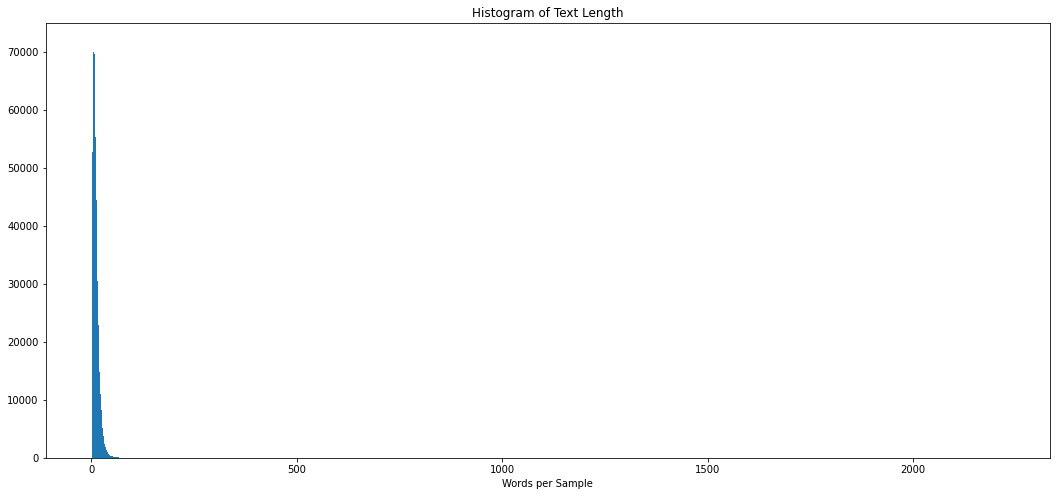

In [9]:
train_data['input_len'] = train_data['text'].str.split().str.len()
eval_data['input_len'] = eval_data['text'].str.split().str.len()

max_len = max(max(train_data['input_len']), max(eval_data['input_len']))
print(f"The maximum length of this dataset is approximately {max_len} words.")

input_lengths = pd.DataFrame()
input_lengths = pd.concat([train_data['input_len'], eval_data['input_len']])

n = max_len
input_lengths.hist(grid=False, figsize=(18,8), range=(0, n), bins=n)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Remove Overly Lengthy Inputs & Unnecessary Features

In [10]:
train_data = train_data[train_data["input_len"] < 250]
eval_data = eval_data[eval_data["input_len"] < 250]


train_data = train_data.drop(columns=["input_len"])
eval_data = eval_data.drop(columns=["input_len"])

train_data.info()
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676493 entries, 0 to 707540
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    676493 non-null  object
dtypes: object(1)
memory usage: 10.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 292916 entries, 0 to 303231
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    292916 non-null  object
dtypes: object(1)
memory usage: 4.5+ MB


#### Convert DataFrame to Dataset

In [11]:
training_dataset = Dataset.from_pandas(train_data)
evaluation_dataset = Dataset.from_pandas(eval_data)

#### Split Dataset into Training & Evaluation Datasets

In [12]:
ds = DatasetDict({
    'train' : training_dataset,
    'eval' : evaluation_dataset
})

print('Training data shape:', ds['train'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (676493, 2)
Eval data shape: (292916, 2)


#### Basic Values/Constants

In [13]:
BLOCK_SIZE = 128
MODEL_CKPT = "bert-base-uncased"

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Masked_Language_Modeling-Reddit_Comments"
set_seed = 42

BATCH_SIZE = 1000
NUM_OF_EPOCHS = 3

WEIGHT_DECAY = 0.01
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
LEARNING_RATE = 2e-5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Tokenize Entire Dataset

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, use_fast=True)

def tokenizer_function(samples):
    return tokenizer(samples["text"])

#### Apply Tokenizer Function to Entire Dataset

In [17]:
tokenized_ds = ds.map(tokenizer_function, 
                      batched=True,
                      num_proc=4,
                      remove_columns=ds["train"].column_names,)

print(tokenized_ds["train"])
print(tokenized_ds["eval"])

Map (num_proc=4):   0%|          | 0/676493 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (919 > 512). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/292916 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (680 > 512). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 676493
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 292916
})


#### Preprocess Tokenized Dataset

In [18]:
def group_texts(samples):
    concatenated_samples = {k: sum(samples[k], []) for k in samples.keys()}
    total_length = len(concatenated_samples[list(samples.keys())[0]])
    
    if total_length >= BLOCK_SIZE:
        total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE
    
    result = {
        k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
        for k, t in concatenated_samples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

#### Apply Preprocessing Function to Dataset

In [19]:
mlm_ds = tokenized_ds.map(
    group_texts,
    batched=True,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/676493 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/292916 [00:00<?, ? examples/s]

#### Instantiate Model

In [20]:
model = (
    AutoModelForMaskedLM.from_pretrained(MODEL_CKPT)
    ).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Define TrainingArguments

In [21]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_OF_EPOCHS,
    report_to=REPORTS_TO,
    logging_first_step=True,
    logging_strategy=STRATEGY,
    save_strategy=STRATEGY,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [22]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

#### Instantiate Trainer

In [23]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=mlm_ds["train"],
    eval_dataset=mlm_ds["eval"],
    data_collator=data_collator,
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-Reddit_Comments into local empty directory.


#### Train Model

In [24]:
train_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,2.875700,2.638240
2,2.681800,2.569892
3,2.610300,2.540241


#### Evaluate Model

In [25]:
evaluation_results = trainer.evaluate()
print(f"Perplexity: {math.exp(evaluation_results['eval_loss']):.2f}")

Perplexity: 12.70


#### Push Model to HuggingFace Hub

In [26]:
trainer.push_to_hub()

Upload file runs/Mar15_17-25-41_8cb5130871e0/events.out.tfevents.1678901147.8cb5130871e0.163.0: 100%|#########…

Upload file runs/Mar15_17-25-41_8cb5130871e0/events.out.tfevents.1678910810.8cb5130871e0.163.2: 100%|#########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-Reddit_Comments
   a5a14a0..fe0600b  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-Reddit_Comments
   a5a14a0..fe0600b  main -> main

To https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-Reddit_Comments
   fe0600b..7960a45  main -> main

   fe0600b..7960a45  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Masked_Language_Modeling-Reddit_Comments/commit/fe0600bae9eb99ba2b2f6118f8a29366701df06a'

### Citations

- Model Checkpoint
> @article{DBLP:journals/corr/abs-1810-04805, author ={Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding},
  journal   = {CoRR},
  volume    = {abs/1810.04805},
  year      = {2018},
  url       = {http://arxiv.org/abs/1810.04805},
  archivePrefix = {arXiv},
  eprint    = {1810.04805},
  timestamp = {Tue, 30 Oct 2018 20:39:56 +0100},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

- Metric (Perplexity)
> @article{jelinek1977perplexity,
title={Perplexity—a measure of the difficulty of speech recognition tasks},
author={Jelinek, Fred and Mercer, Robert L and Bahl, Lalit R and Baker, James K},
journal={The Journal of the Acoustical Society of America},
volume={62},
number={S1},
pages={S63--S63},
year={1977},
publisher={Acoustical Society of America}
}

